In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
df = pd.read_csv("C:/Users/Димон/Downloads/prepared_data.csv")

In [3]:
# Кодирование категориальных переменных
label_encoders = {}
categorical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Разделение на признаки и целевую переменную
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

In [4]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Масштабирование числовых признаков
scaler = StandardScaler()
numerical_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Создание и обучение модели Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

print("\nОбучение модели Random Forest...")
rf_model.fit(X_train, y_train)


Обучение модели Random Forest...


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",2
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [5]:
# Прогнозирование на тестовой выборке
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)

# Оценка модели
print("\n" + "="*50)
print("ОЦЕНКА МОДЕЛИ RANDOM FOREST")
print("="*50)

print(f"\nТочность (Accuracy): {accuracy_score(y_test, y_pred):.4f}")

print("\nОтчет классификации:")
print(classification_report(y_test, y_pred, 
                           target_names=label_encoders['NObeyesdad'].classes_))

# Кросс-валидация
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nКросс-валидация (5 фолдов):")
print(f"Средняя точность: {cv_scores.mean():.4f}")
print(f"Стандартное отклонение: {cv_scores.std():.4f}")


ОЦЕНКА МОДЕЛИ RANDOM FOREST

Точность (Accuracy): 0.9314

Отчет классификации:
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.93      0.96        54
      Normal_Weight       0.80      0.88      0.84        58
     Obesity_Type_I       0.94      0.94      0.94        70
    Obesity_Type_II       1.00      0.98      0.99        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.86      0.86      0.86        58
Overweight_Level_II       0.93      0.93      0.93        58

           accuracy                           0.93       423
          macro avg       0.93      0.93      0.93       423
       weighted avg       0.93      0.93      0.93       423


Кросс-валидация (5 фолдов):
Средняя точность: 0.9372
Стандартное отклонение: 0.0134


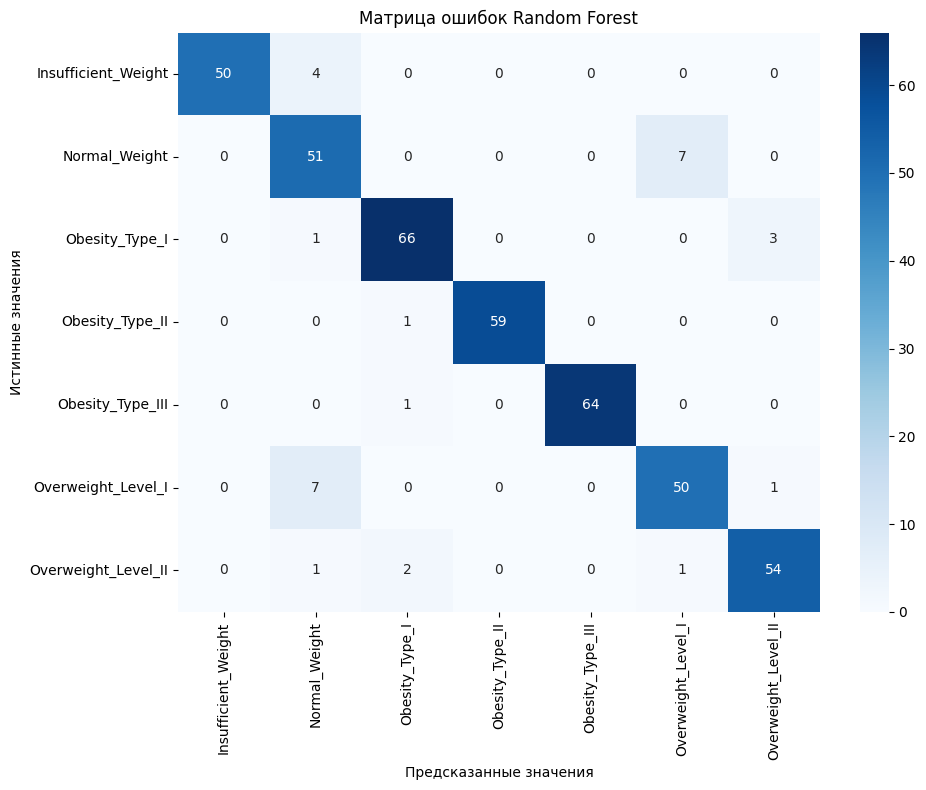


ВАЖНОСТЬ ПРИЗНАКОВ
                           Признак  Важность
3                           Weight  0.409117
2                           Height  0.118957
1                              Age  0.100027
0                           Gender  0.073848
7                              NCP  0.061599
8                             CAEC  0.037479
14                            CALC  0.034882
4   family_history_with_overweight  0.033691
6                             FCVC  0.031687
12                             FAF  0.023153
15                          MTRANS  0.021139
5                             FAVC  0.017421
13                             TUE  0.016690
10                            CH2O  0.014955
11                             SCC  0.004727
9                            SMOKE  0.000628


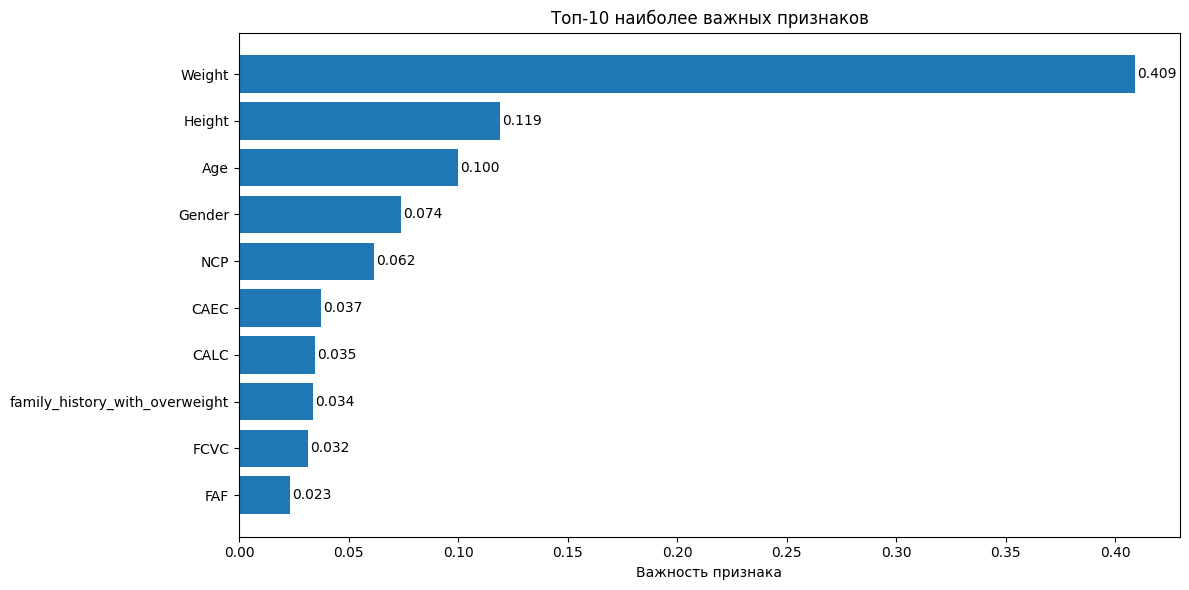

In [ ]:
# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoders['NObeyesdad'].classes_,
            yticklabels=label_encoders['NObeyesdad'].classes_)
plt.title('Матрица ошибок Random Forest')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.tight_layout()
plt.show()

# Важность признаков
feature_importance = pd.DataFrame({
    'Признак': X.columns,
    'Важность': rf_model.feature_importances_
}).sort_values('Важность', ascending=False)

print("\n" + "="*50)
print("ВАЖНОСТЬ ПРИЗНАКОВ")
print("="*50)
print(feature_importance)

# Визуализация важности признаков
plt.figure(figsize=(12, 6))
bars = plt.barh(feature_importance['Признак'][:10], 
                feature_importance['Важность'][:10])
plt.xlabel('Важность признака')
plt.title('Топ-10 наиболее важных признаков')
plt.gca().invert_yaxis()

# Добавление значений на график
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center')

plt.tight_layout()
plt.show()

In [16]:


# Подбор гиперпараметров
print("\n" + "="*50)
print("ПОДБОР ГИПЕРПАРАМЕТРОВ (Grid Search)")
print("="*50)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Создание GridSearchCV
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Запуск GridSearch...")
grid_search.fit(X_train, y_train)

print(f"\nЛучшие параметры: {grid_search.best_params_}")
print(f"Лучшая точность: {grid_search.best_score_:.4f}")


ПОДБОР ГИПЕРПАРАМЕТРОВ (Grid Search)
Запуск GridSearch...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Лучшие параметры: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Лучшая точность: 0.9461


In [17]:

# Обучение модели с лучшими параметрами
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

y_pred_best = best_rf_model.predict(X_test)
print(f"\nТочность на тестовой выборке (лучшая модель): {accuracy_score(y_test, y_pred_best):.4f}")


Точность на тестовой выборке (лучшая модель): 0.9527
